# Installs & Imports

In [ ]:
!pip install Pillow -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

from PIL import Image
import imageio

import pickle
import random
import argparse
import copy
import json
import os
import sys
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.transforms import ElasticTransform, InterpolationMode
from torchvision.utils import make_grid

from google.colab import drive
drive.mount('/content/drive')

# Set random seed for reproducibility
seed = 123
print("Random Seed:", seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Random Seed: 123


# Loading the Data

## Image Data

In [ ]:
# Download the CelebA dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-01-01 19:33:39--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.220.152, 52.219.112.56, 52.219.220.208, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.220.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  17.0MB/s    in 85s     

2024-01-01 19:35:04 (16.3 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
# Unzip the dataset
!unzip -qq celeba.zip

In [ ]:
# List the contents in the current directory
!ls -l

total 1415448
-rw-r--r-- 1 root root 1443490838 Apr 21  2017 celeba.zip
drwx------ 5 root root       4096 Jan  1 19:33 drive
drwxr-xr-x 2 root root    5910528 Sep 28  2015 img_align_celeba
drwxr-xr-x 1 root root       4096 Dec 19 14:20 sample_data


In [ ]:
# List the contents of the dataset directory
!ls img_align_celeba | head

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


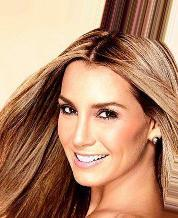

In [ ]:
# Display an image from the dataset
from IPython.display import Image

test_image = Image('img_align_celeba/000001.jpg')
test_image

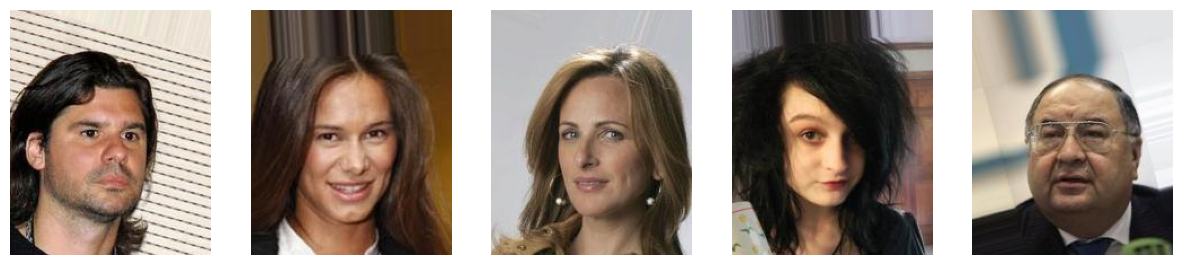

In [ ]:
from PIL import Image

# Directory containing images
image_dir = 'img_align_celeba/'

# Display first few images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, file in enumerate(os.listdir(image_dir)[:5]):
    img_path = os.path.join(image_dir, file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [ ]:
# Count the number of images
num_images = len(os.listdir(image_dir))
print(f"Total number of images: {num_images}")

# Get all filenames in the directory
all_filenames = os.listdir(image_dir)

# Randomly select 5 filenames
random_filenames = random.sample(all_filenames, 5)

# Loop through the selected filenames and print their sizes
for i, filename in enumerate(random_filenames, start=1):
    img_path = os.path.join(image_dir, filename)
    img = Image.open(img_path)
    print(f"Image {filename}: Size {img.size}")

Total number of images: 202599
Image 084239.jpg: Size (178, 218)
Image 017364.jpg: Size (178, 218)
Image 088844.jpg: Size (178, 218)
Image 020462.jpg: Size (178, 218)
Image 087626.jpg: Size (178, 218)


## Identity Data

In [ ]:
# Copy identity file to the notebook
!cp "/content/drive/My Drive/Datasets/CelebA/identity_CelebA.txt" /content/

In [ ]:
# Load the identity file
identities = pd.read_csv('identity_CelebA.txt', delim_whitespace=True, header=None,
                       names=['filename', 'identity'])

# Display the first few lines of the DataFrame
identities.head()

filename  identity
0  000001.jpg      2880
1  000002.jpg      2937
2  000003.jpg      8692
3  000004.jpg      5805
4  000005.jpg      9295

In [ ]:
# Count unique individuals
unique_individuals = identities['identity'].nunique()
print(f"Number of unique individuals: {unique_individuals}")

# Analyze distribution of images per individual
image_count_per_individual = identities['identity'].value_counts()
print(image_count_per_individual.describe())

Number of unique individuals: 10177
count    10177.000000
mean        19.907537
std          8.925916
min          1.000000
25%         13.000000
50%         21.000000
75%         29.000000
max         35.000000
Name: identity, dtype: float64


<Axes: >

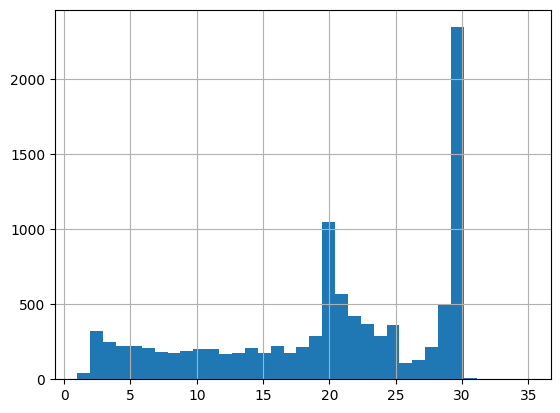

In [ ]:
# Plot the distribution
image_count_per_individual.hist(bins=35)

In [ ]:
# Find the top 10 individuals with the most images
top_individuals = image_count_per_individual.sort_values(ascending=False)[:10]
print(top_individuals)

3227    35
3782    35
2820    35
3745    34
3699    34
9152    32
8968    32
9256    32
4740    31
9840    31
Name: identity, dtype: int64


In [ ]:
# Filter the DataFrame to only include the top individuals
top_individuals_ids = top_individuals.index
top_individuals_df = identities[identities['identity'].isin(top_individuals_ids)]

# Display the first few lines of the DataFrame
top_individuals_df.head()

filename  identity
1552  001553.jpg      2820
2278  002279.jpg      3745
2557  002558.jpg      2820
3567  003568.jpg      2820
3646  003647.jpg      3745

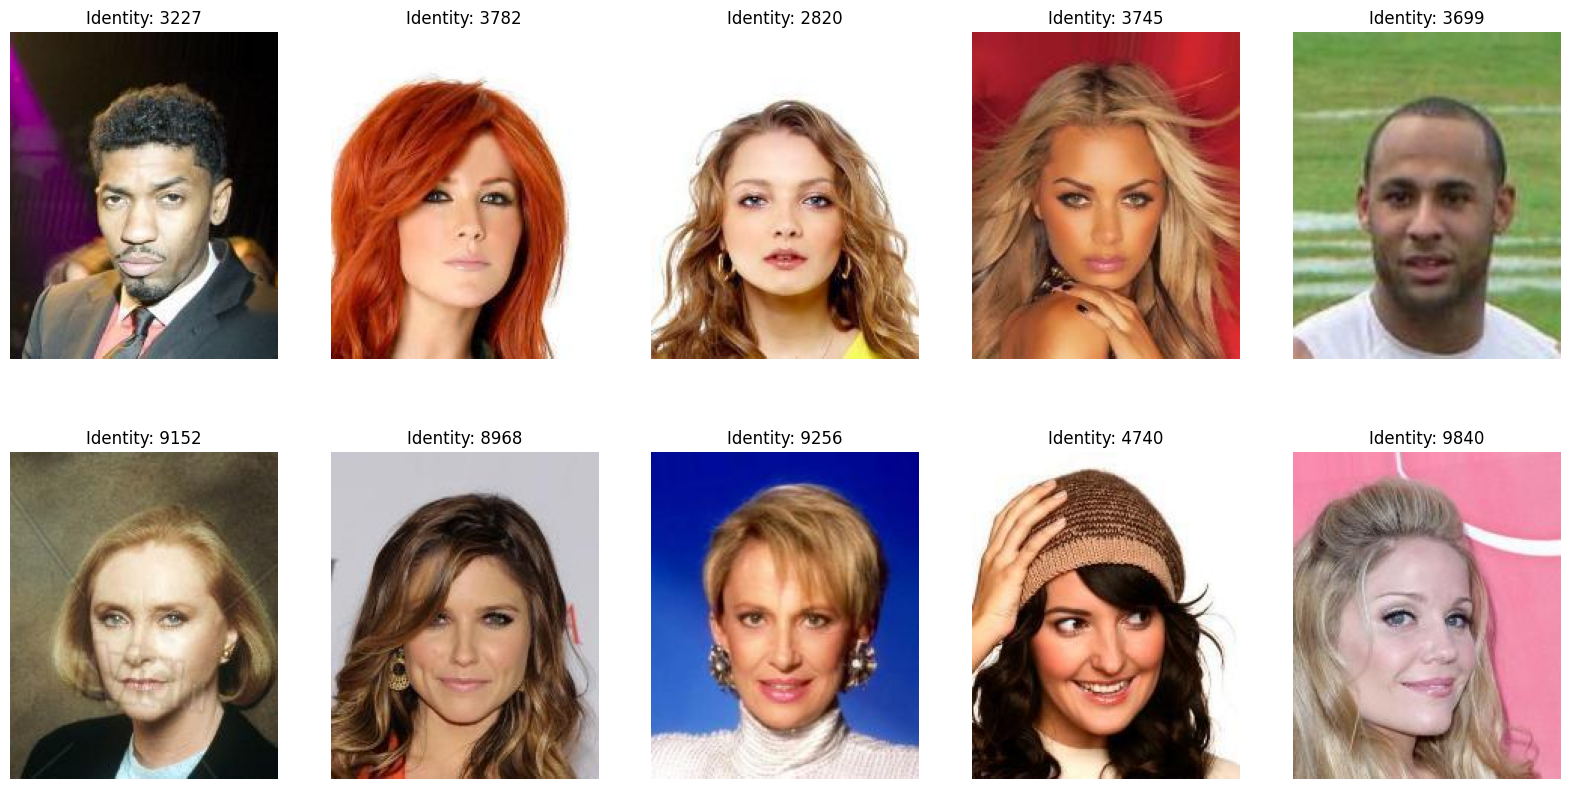

In [ ]:
# Create a dictionary to hold one filename per individual
top_images = {}

# Loop through the individuals and select the first filename for each
for individual in top_individuals_ids:
  top_images[individual] = top_individuals_df[top_individuals_df['identity'] == individual].iloc[0]['filename']

# Display an image for each top individual with the corresponding identity label
plt.figure(figsize=(20, 10))
for i, (individual_id, filename) in enumerate(top_images.items(), start=1):
  # Load the image
  img_path = os.path.join(image_dir, filename)
  img = Image.open(img_path)

  # Plotting
  plt.subplot(2, 5, i)
  plt.imshow(img)
  plt.title(f"Identity: {individual_id}")
  plt.axis('off')

plt.show()

## Attribute Data

In [ ]:
# Copy attributes file to the notebook
!cp "/content/drive/My Drive/Datasets/CelebA/list_attr_celeba.txt" /content/

In [ ]:
# Load the attributes file
attributes = pd.read_csv('list_attr_celeba.txt', sep="\s+", header=1)

# Display the first few lines of the DataFrame
attributes.head()

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
000001.jpg         -1        1              1         -1                 1   
000002.jpg         -1        1             -1         -1                -1   
000003.jpg         -1       -1             -1          1                -1   
000004.jpg         -1       -1              1         -1                 1   
000005.jpg         -1       -1             -1         -1                -1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
000001.jpg           -1                 1                -1               -1   
000002.jpg           -1                -1                -1               -1   
000003.jpg           -1                -1                -1               -1   
000004.jpg           -1                 1                 1               -1   
000005.jpg           -1                 1                -1               -1   

            Young  
000001.jpg      1  
000002.jpg      1  
000003.jpg      1  
000004.jpg      1  
000005.jpg      1  

[5 rows x 40 columns]

In [ ]:
# Display attributes columns
print(attributes.columns)

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')


In [ ]:
# Get basic statistics
attributes.describe()

5_o_Clock_Shadow  Arched_Eyebrows    Attractive  Bags_Under_Eyes  \
count     202599.000000    202599.000000  202599.00000    202599.000000   
mean          -0.777728        -0.466039       0.02501        -0.590857   
std            0.628602         0.884766       0.99969         0.806778   
min           -1.000000        -1.000000      -1.00000        -1.000000   
25%           -1.000000        -1.000000      -1.00000        -1.000000   
50%           -1.000000        -1.000000       1.00000        -1.000000   
75%           -1.000000         1.000000       1.00000        -1.000000   
max            1.000000         1.000000       1.00000         1.000000   

                Bald          Bangs       Big_Lips       Big_Nose  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       -0.955113      -0.696849      -0.518408      -0.530935   
std         0.296241       0.717219       0.855135       0.847414   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%        -1.000000      -1.000000      -1.000000      -1.000000   
75%        -1.000000      -1.000000      -1.000000      -1.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Black_Hair     Blond_Hair  ...      Sideburns        Smiling  \
count  202599.000000  202599.000000  ...  202599.000000  202599.000000   
mean       -0.521498      -0.704016  ...      -0.886979      -0.035839   
std         0.853255       0.710186  ...       0.461811       0.999360   
min        -1.000000      -1.000000  ...      -1.000000      -1.000000   
25%        -1.000000      -1.000000  ...      -1.000000      -1.000000   
50%        -1.000000      -1.000000  ...      -1.000000      -1.000000   
75%        -1.000000      -1.000000  ...      -1.000000       1.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

       Straight_Hair      Wavy_Hair  Wearing_Earrings    Wearing_Hat  \
count  202599.000000  202599.000000      202599.00000  202599.000000   
mean       -0.583196      -0.360866          -0.62215      -0.903079   
std         0.812333       0.932620           0.78290       0.429475   
min        -1.000000      -1.000000          -1.00000      -1.000000   
25%        -1.000000      -1.000000          -1.00000      -1.000000   
50%        -1.000000      -1.000000          -1.00000      -1.000000   
75%        -1.000000       1.000000          -1.00000      -1.000000   
max         1.000000       1.000000           1.00000       1.000000   

       Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie          Young  
count     202599.000000     202599.000000    202599.000000  202599.000000  
mean          -0.055129         -0.754066        -0.854570       0.547234  
std            0.998482          0.656800         0.519338       0.836982  
min           -1.000000         -1.000000        -1.000000      -1.000000  
25%           -1.000000         -1.000000        -1.000000       1.000000  
50%           -1.000000         -1.000000        -1.000000       1.000000  
75%            1.000000         -1.000000        -1.000000       1.000000  
max            1.000000          1.000000         1.000000       1.000000  

[8 rows x 40 columns]

In [ ]:
# Filter images by attribute
def display_filtered_images(attributes, attribute_name, value, image_dir, num_images=5):
  """
  Displays images from the CelebA dataset filtered by a specific attribute.

  Args:
    attributes: DataFrame containing the CelebA dataset
    attribute_name: Name of the attribute to filter by
    value: Value of the attribute to filter by
    image_dir: Directory containing the CelebA images
    num_images: Number of images to display
  """
  # Filter images based on the attribute
  filtered_df = attributes[attributes[attribute_name] == value]

  # Get the index (filenames) of the 'num_images' filtered images
  filtered_filenames = filtered_df.head(num_images).index.tolist()

  # Display the specified number of filtered images
  fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
  for i, filename in enumerate(filtered_filenames):
    img_path = os.path.join(image_dir, filename)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
  plt.show()

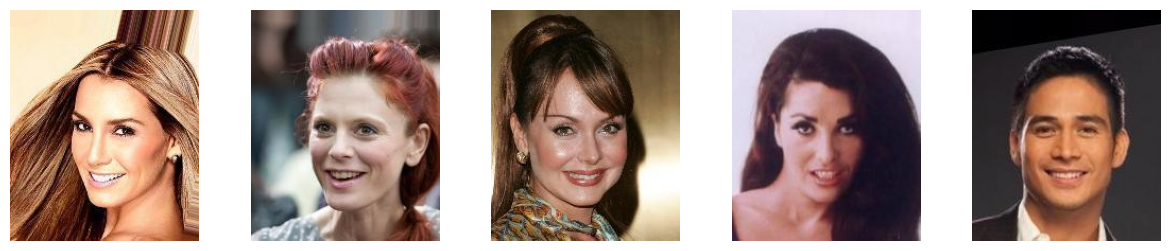

In [ ]:
# Call the function
display_filtered_images(attributes, 'Smiling', 1, image_dir, num_images=5)

In [ ]:
# Get attribute distribution
attribute_distribution = attributes.sum().sort_values(ascending=False)
attribute_distribution

No_Beard               135717
Young                  110869
Attractive               5067
Mouth_Slightly_Open     -6715
Smiling                 -7261
Wearing_Lipstick       -11169
High_Cheekbones        -18221
Male                   -33731
Heavy_Makeup           -45819
Wavy_Hair              -73111
Oval_Face              -87465
Pointy_Nose            -90179
Arched_Eyebrows        -94419
Big_Lips              -105029
Black_Hair            -105655
Big_Nose              -107567
Straight_Hair         -118155
Brown_Hair            -119455
Bags_Under_Eyes       -119707
Wearing_Earrings      -126047
Bangs                 -141181
Blond_Hair            -142633
Bushy_Eyebrows        -144993
Wearing_Necklace      -152773
Narrow_Eyes           -155941
5_o_Clock_Shadow      -157567
Receding_Hairline     -170273
Wearing_Necktie       -173135
Rosy_Cheeks           -175969
Eyeglasses            -176213
Goatee                -177167
Chubby                -179273
Sideburns             -179701
Blurry    

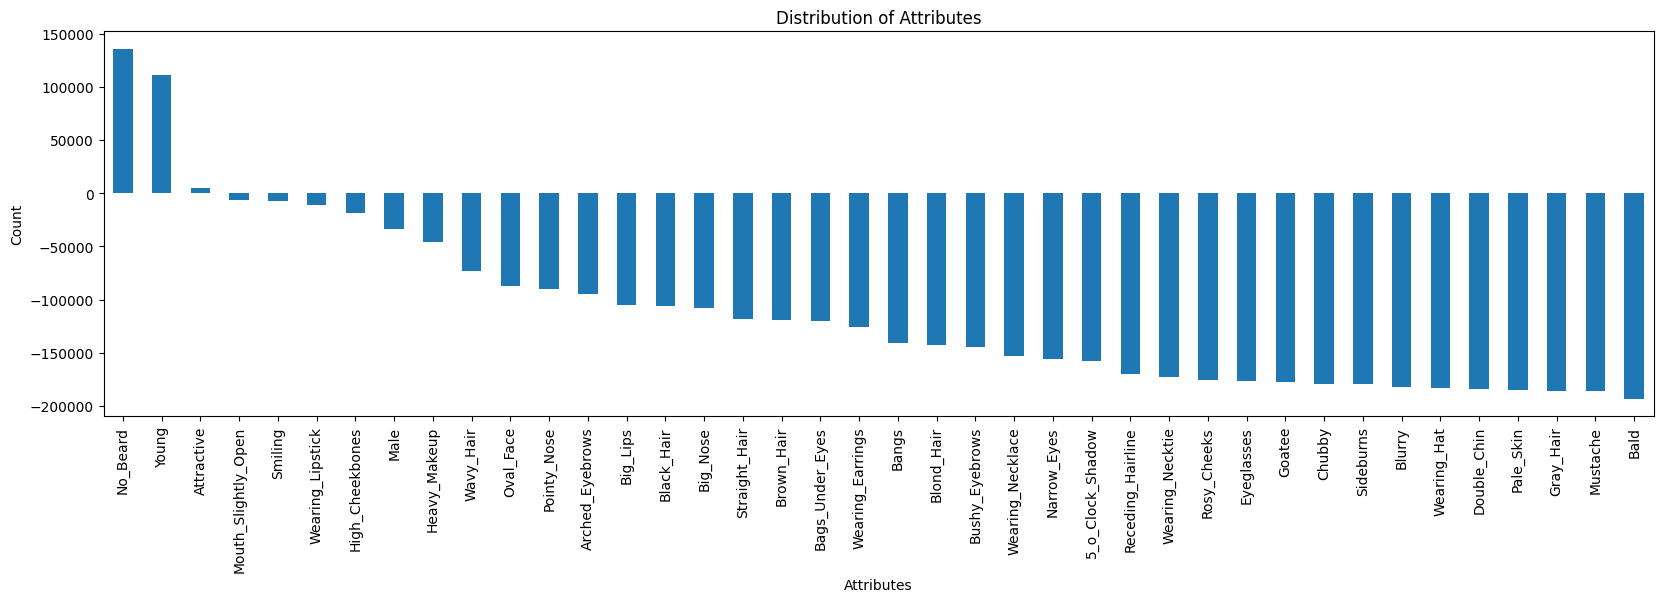

In [ ]:
# Visualize the distribution
attribute_distribution.plot(kind='bar', figsize=(20, 5))
plt.title('Distribution of Attributes')
plt.ylabel('Count')
plt.xlabel('Attributes')
plt.show()

In [ ]:
# Calculate the number of times each attribute is present (1)
attribute_present = (attributes == 1).sum()

# Calculate the number of times each attribute is absent (-1)
attribute_absent = (attributes == -1).sum()

# Combine into a DataFrame
attribute_distribution_df = pd.DataFrame({'Present': attribute_present, 'Absent': attribute_absent})

# Sort the DataFrame by the number of times present
attribute_distribution_df = attribute_distribution_df.sort_values(by='Present', ascending=False)
attribute_distribution_df

Present  Absent
No_Beard              169158   33441
Young                 156734   45865
Attractive            103833   98766
Mouth_Slightly_Open    97942  104657
Smiling                97669  104930
Wearing_Lipstick       95715  106884
High_Cheekbones        92189  110410
Male                   84434  118165
Heavy_Makeup           78390  124209
Wavy_Hair              64744  137855
Oval_Face              57567  145032
Pointy_Nose            56210  146389
Arched_Eyebrows        54090  148509
Big_Lips               48785  153814
Black_Hair             48472  154127
Big_Nose               47516  155083
Straight_Hair          42222  160377
Brown_Hair             41572  161027
Bags_Under_Eyes        41446  161153
Wearing_Earrings       38276  164323
Bangs                  30709  171890
Blond_Hair             29983  172616
Bushy_Eyebrows         28803  173796
Wearing_Necklace       24913  177686
Narrow_Eyes            23329  179270
5_o_Clock_Shadow       22516  180083
Receding_Hairline      16163  186436
Wearing_Necktie        14732  187867
Rosy_Cheeks            13315  189284
Eyeglasses             13193  189406
Goatee                 12716  189883
Chubby                 11663  190936
Sideburns              11449  191150
Blurry                 10312  192287
Wearing_Hat             9818  192781
Double_Chin             9459  193140
Pale_Skin               8701  193898
Gray_Hair               8499  194100
Mustache                8417  194182
Bald                    4547  198052

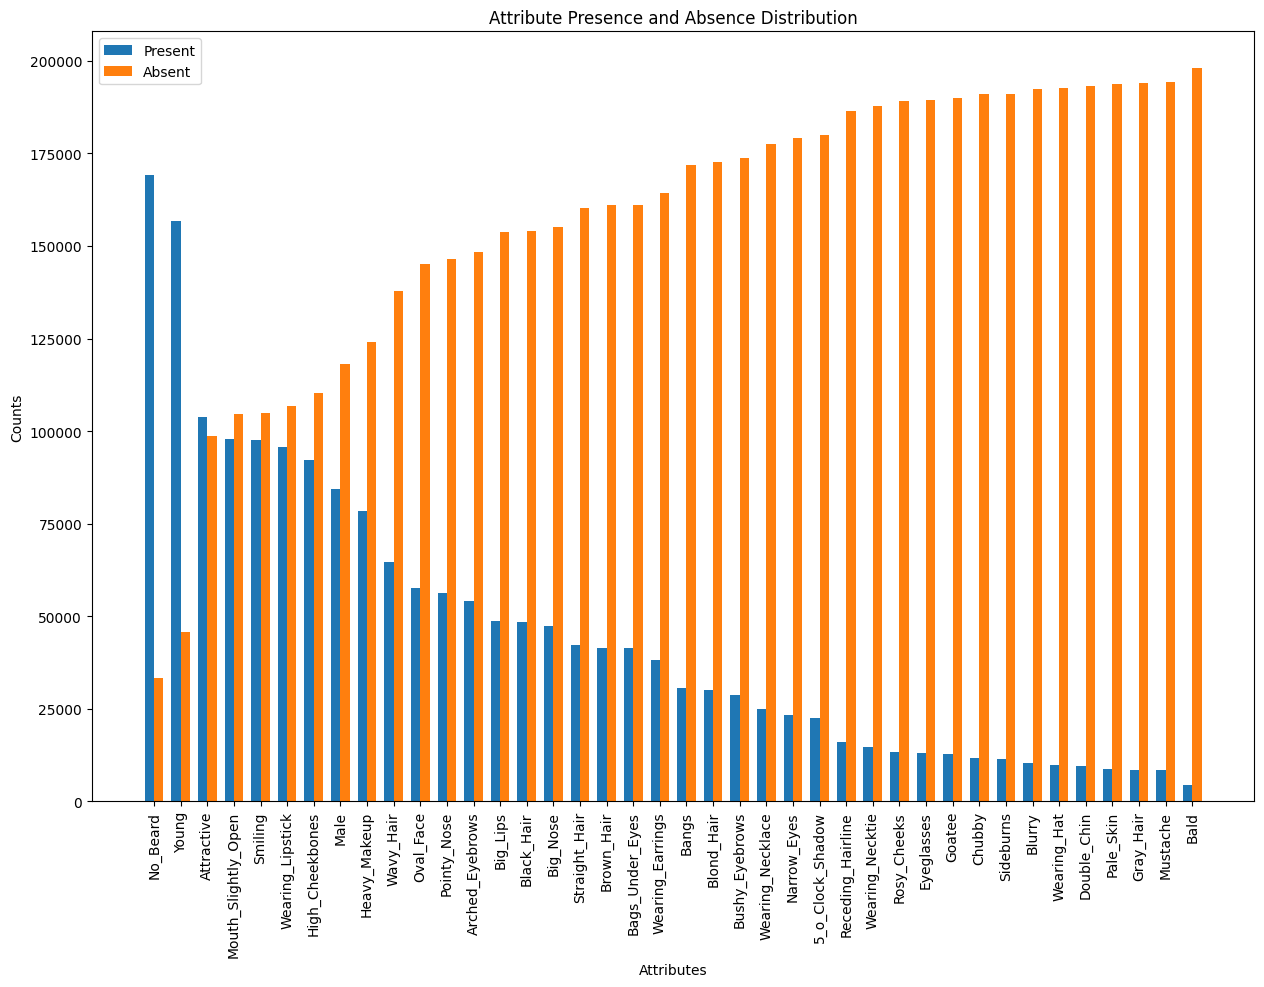

In [ ]:
# Plot the presence and absence counts side by side for each attribute
fig, ax = plt.subplots(figsize=(15, 10))

indices = range(len(attribute_distribution_df))
width = 0.35  # Width of the bars

# For the 'Present' count
present_bars = ax.bar(indices, attribute_distribution_df['Present'], width, label='Present')

# For the 'Absent' count, with an offset of 'width' to put it next to the 'Present' bars
absent_bars = ax.bar([i + width for i in indices], attribute_distribution_df['Absent'], width, label='Absent')

# Add labels, title and tick labels
ax.set_xlabel('Attributes')
ax.set_ylabel('Counts')
ax.set_title('Attribute Presence and Absence Distribution')
ax.set_xticks([i + width / 2 for i in indices])
ax.set_xticklabels(attribute_distribution_df.index, rotation='vertical')
ax.legend()

plt.show()

-1    104930
 1     97669
Name: Smiling, dtype: int64


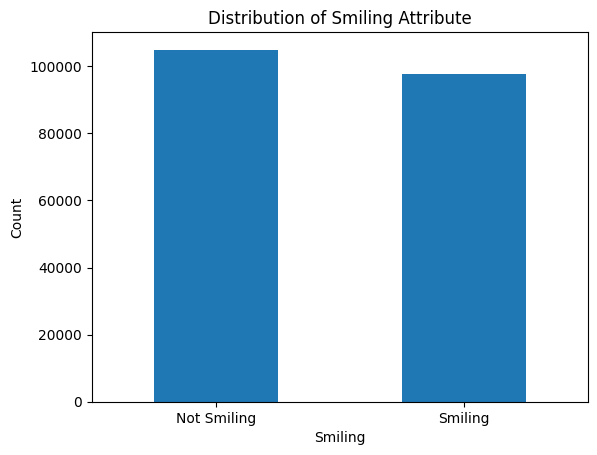

In [ ]:
# Analyze the distribution of the "Smiling" attribute
smiling_counts = attributes['Smiling'].value_counts()
print(smiling_counts)

# Plot the distribution
smiling_counts.plot(kind='bar')
plt.title('Distribution of Smiling Attribute')
plt.xlabel('Smiling')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Smiling', 'Smiling'], rotation=0)
plt.show()

In [ ]:
# Calculate correlations between attributes
correlation_matrix = attributes.corr()

# View the correlation between "Smiling" and "Male"
smiling_male_corr = correlation_matrix.loc['Smiling', 'Male']
print(f"Smiling and Male Correlation: {smiling_male_corr}")

# View the correlation between "Smiling" and "Female"
smiling_female_corr = -smiling_male_corr
print(f"Smiling and Female Correlation: {smiling_female_corr}")

Smiling and Male Correlation: -0.1383664797747885
Smiling and Female Correlation: 0.1383664797747885


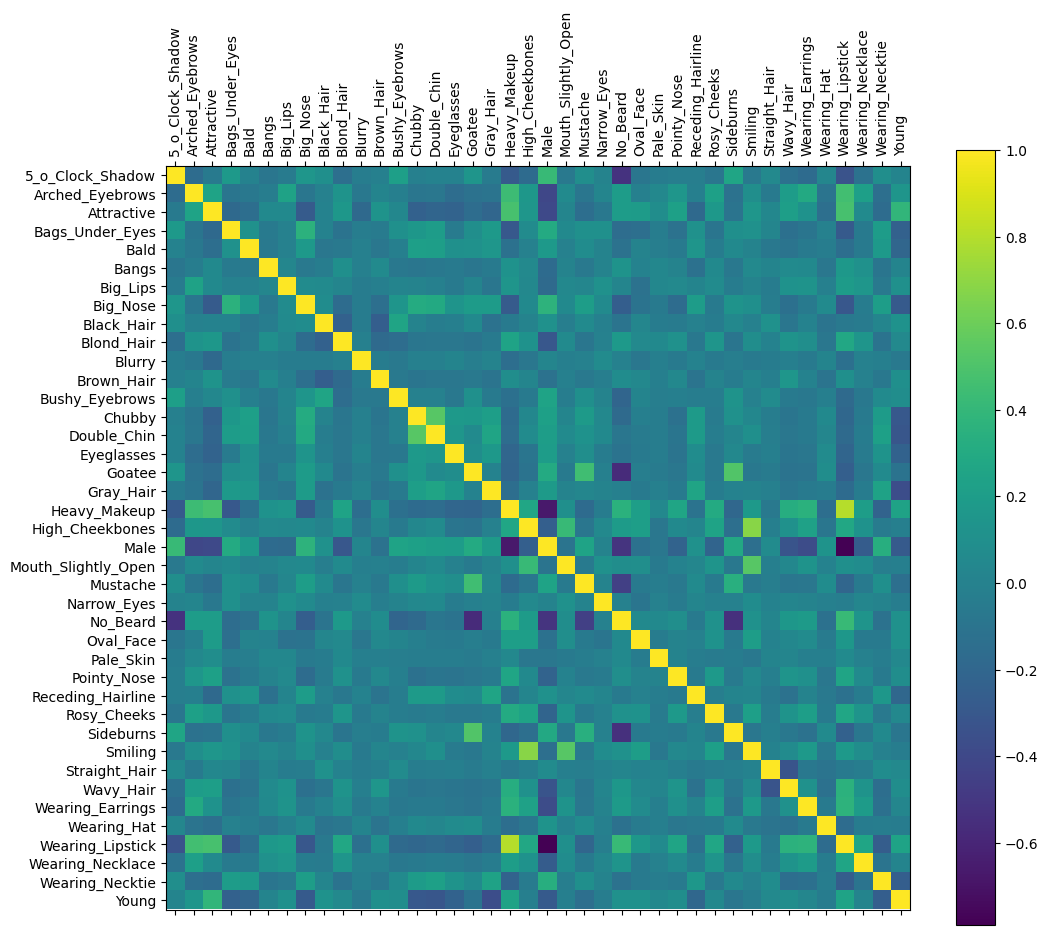

In [ ]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()

## Landmark Data

In [ ]:
# Copy landmarks file to the notebook
!cp "/content/drive/My Drive/Datasets/CelebA/list_landmarks_align_celeba.txt" /content/

In [ ]:
# Load the landmarks file
landmarks = pd.read_csv('list_landmarks_align_celeba.txt', delim_whitespace=True, header=1)

# Display the first few lines of the DataFrame
landmarks.head()

lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
000001.jpg         69        109         106         113      77     142   
000002.jpg         69        110         107         112      81     135   
000003.jpg         76        112         104         106     108     128   
000004.jpg         72        113         108         108     101     138   
000005.jpg         66        114         112         112      86     119   

            leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
000001.jpg           73          152           108           154  
000002.jpg           70          151           108           153  
000003.jpg           74          156            98           158  
000004.jpg           71          155           101           151  
000005.jpg           71          147           104           150

In [ ]:
# Get basic statistics
landmarks.describe()

lefteye_x      lefteye_y     righteye_x     righteye_y  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       69.353867     111.197982     107.644031     111.161600   
std         1.717952       1.129284       1.690252       1.169229   
min        56.000000      98.000000      90.000000      95.000000   
25%        68.000000     111.000000     107.000000     111.000000   
50%        69.000000     111.000000     108.000000     111.000000   
75%        70.000000     112.000000     109.000000     112.000000   
max        88.000000     129.000000     124.000000     122.000000   

              nose_x         nose_y    leftmouth_x    leftmouth_y  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       88.063140     135.102024      71.247459     152.113011   
std         6.647733       4.245078       3.168011       1.799343   
min        57.000000      93.000000      57.000000     116.000000   
25%        84.000000     133.000000      69.000000     151.000000   
50%        88.000000     135.000000      72.000000     152.000000   
75%        92.000000     138.000000      73.000000     153.000000   
max       121.000000     156.000000      90.000000     174.000000   

        rightmouth_x   rightmouth_y  
count  202599.000000  202599.000000  
mean      105.586429     152.194660  
std         3.233125       1.752368  
min        82.000000     114.000000  
25%       103.000000     151.000000  
50%       105.000000     152.000000  
75%       108.000000     153.000000  
max       120.000000     173.000000

In [ ]:
# Extract eye landmarks
eye_left_x = landmarks['lefteye_x']
eye_left_y = landmarks['lefteye_y']
eye_right_x = landmarks['righteye_x']
eye_right_y = landmarks['righteye_y']

# Calculate the average position of each eye
average_eye_left = (eye_left_x.mean(), eye_left_y.mean())
average_eye_right = (eye_right_x.mean(), eye_right_y.mean())

print("Average Left Eye Position:", average_eye_left)
print("Average Right Eye Position:", average_eye_right)

Average Left Eye Position: (69.35386650477051, 111.19798222103762)
Average Right Eye Position: (107.64403081950059, 111.16160000789738)


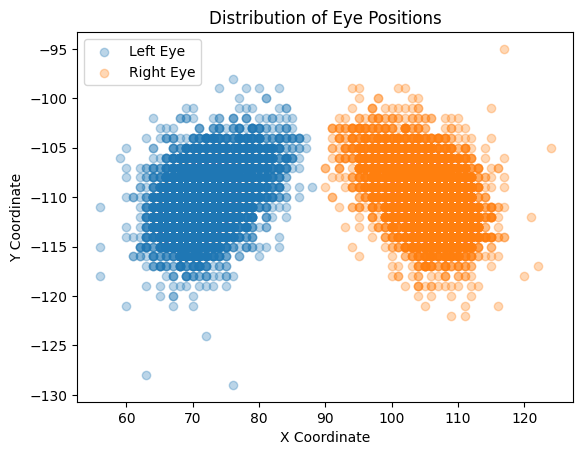

In [ ]:
# Plot the eye positions
plt.scatter(eye_left_x, -eye_left_y, alpha=0.3, label='Left Eye')
plt.scatter(eye_right_x, -eye_right_y, alpha=0.3, label='Right Eye')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.title('Distribution of Eye Positions')
plt.show()

In [ ]:
# Analyze distance between eyes
eye_distance = np.sqrt((eye_left_x - eye_right_x) ** 2 + (eye_left_y - eye_right_y) ** 2)
print("Average Distance Between Eyes:", eye_distance.mean())

Average Distance Between Eyes: 38.33126045458157


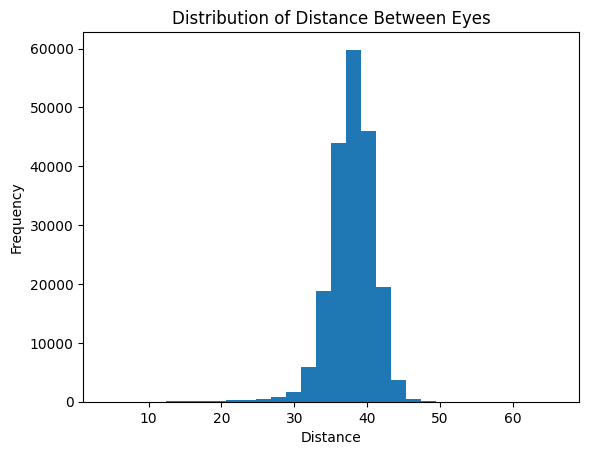

In [ ]:
# Plot the distribution of eye distances
plt.hist(eye_distance, bins=30)
plt.title('Distribution of Distance Between Eyes')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Extract nose landmarks
nose_x = landmarks['nose_x']
nose_y = landmarks['nose_y']

In [ ]:
# Calculate the average position of the nose
average_nose = (nose_x.mean(), nose_y.mean())
print(f"Average nose position", average_nose)

Average nose position (88.0631395021693, 135.10202419557845)


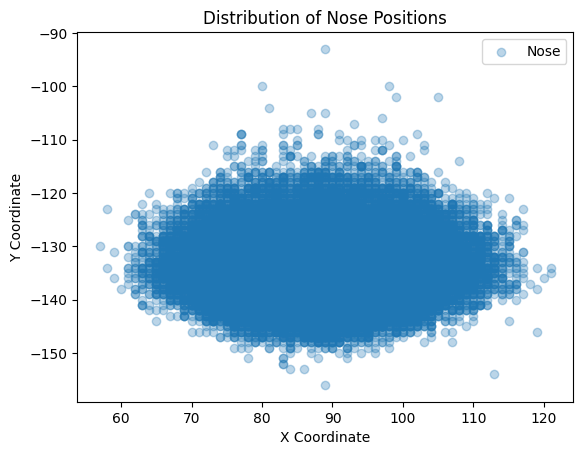

In [ ]:
# Plot the nose positions
plt.scatter(nose_x, -nose_y, alpha=0.3, label='Nose')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.title('Distribution of Nose Positions')
plt.show()

In [ ]:
# Extract mouth landmarks
mouth_left_x = landmarks['leftmouth_x']
mouth_left_y = landmarks['leftmouth_y']
mouth_right_x = landmarks['rightmouth_x']
mouth_right_y = landmarks['rightmouth_y']

In [ ]:
# Calculate the average positions of the corners of the mouth
average_mouth_left = (mouth_left_x.mean(), mouth_left_y.mean())
average_mouth_right = (mouth_right_x.mean(), mouth_right_y.mean())

print("Average Left Mouth Corner Position:", average_mouth_left)
print("Average Right Mouth Corner Position:", average_mouth_right)

Average Left Mouth Corner Position: (71.24745926682758, 152.11301141664075)
Average Right Mouth Corner Position: (105.5864293505891, 152.19466038825462)


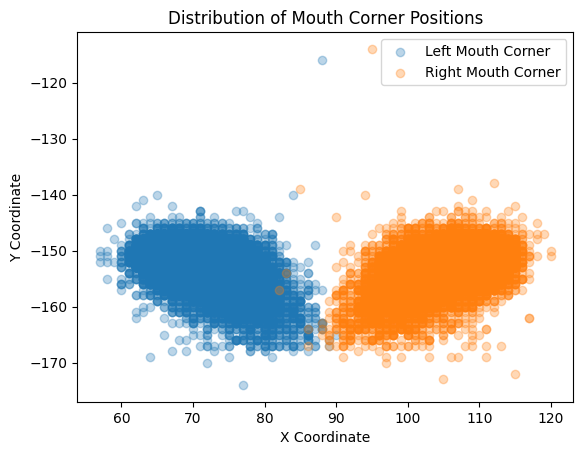

In [ ]:
# Plot the mouth positions
plt.scatter(mouth_left_x, -mouth_left_y, alpha=0.3, label='Left Mouth Corner')
plt.scatter(mouth_right_x, -mouth_right_y, alpha=0.3, label='Right Mouth Corner')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.title('Distribution of Mouth Corner Positions')
plt.show()

In [ ]:
# Analyze distance between mouth corners
mouth_distance = np.sqrt((mouth_left_x - mouth_right_x) ** 2 + (mouth_left_y - mouth_right_y) ** 2)
print("Average Distance Between Mouth Corners:", mouth_distance.mean())

Average Distance Between Mouth Corners: 34.39489338198948


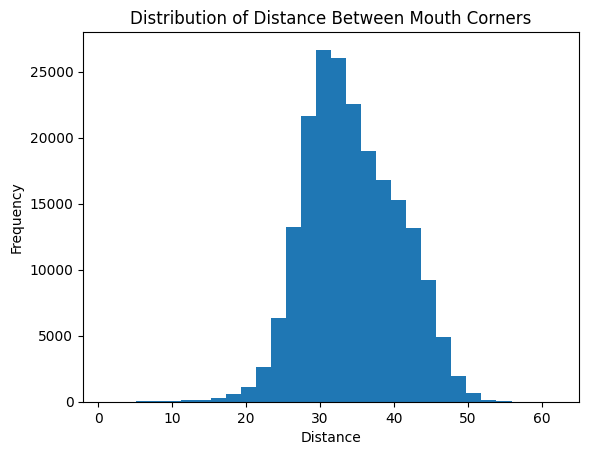

In [ ]:
# Plot the distribution of distances between mouth corners
plt.hist(mouth_distance, bins=30)
plt.title('Distribution of Distance Between Mouth Corners')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Preprocessing the Data

## Splitting the Data

In [ ]:
# Image directory
image_dir = 'img_align_celeba/'

# Get all image file paths
all_image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

# Shuffle the dataset
random.shuffle(all_image_paths)

In [ ]:
# Split the data into train, validation, and test sets (90/5/5)
train_paths, test_val_paths = train_test_split(all_image_paths, test_size=0.1, random_state=42)
val_paths, test_paths = train_test_split(test_val_paths, test_size=0.5, random_state=42)

## Transformations

In [ ]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Define the image size for resizing operations
image_size = 64

# Define the batch size
batch_size = 128

In [ ]:
# Define transformations for the training set
train_transformations = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Define transformations for the validation and test sets
test_val_transformations = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

## Dataset & DataLoader

In [ ]:
# Create the Dataset objects
train_dataset = CustomDataset(train_paths, transform=train_transformations)
val_dataset = CustomDataset(val_paths, transform=test_val_transformations)
test_dataset = CustomDataset(test_paths, transform=test_val_transformations)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         drop_last=True, num_workers=4, pin_memory=True)

In [ ]:
# Number of GPUs
ngpu = 1

# Set the device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("The current device is set to:", device)

The current device is set to: cuda:0


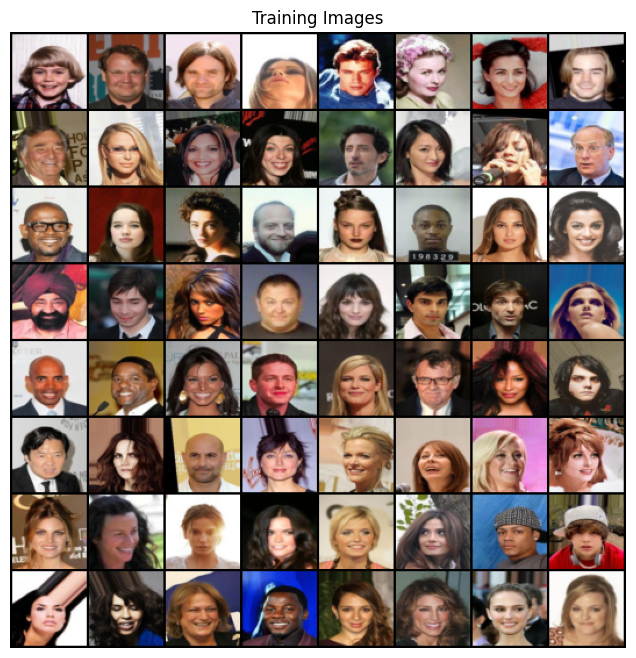

In [ ]:
# Test the DataLoader and visualize images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)));

In [ ]:
# Print the output shape
sample_batch = next(iter(train_loader))
print("Batch shape from DataLoader:", sample_batch.shape)

Batch shape from DataLoader: torch.Size([128, 3, 64, 64])


# DCGAN

## Parameters

In [ ]:
# Network parameters
nc = 3
nz = 100
ngf = 64
ndf = 64

## Weights Function

In [ ]:
# Weights initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Network

In [ ]:
# Generator network
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

            # State size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Discriminator Network

In [ ]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Initializations

In [ ]:
# Set the number of epochs
num_epochs = 10

# Learning rate and beta for Adam optimizers
lr = 0.0002
beta1 = 0.5

In [ ]:
# Initialize the Generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Initialize the Discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Print the models to verify architecture
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Initialize the loss function
criterion = nn.BCELoss()

# Create batch of latent vectors for visualization
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels
real_label = 1.0
fake_label = 0.0

# Set the optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Loop

In [ ]:
# Training loop function
def train_gan(
    netG, netD,
    criterion,
    optimizerG,
    optimizerD,
    train_loader,
    num_epochs,
    device
  ):
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    # Initialize best loss to a high value
    best_g_loss = float('inf')

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader, 0):
            ########################
            # (1) Update D network #
            ########################
            ## Train with all-real batch
            netD.zero_grad()

            # Format batch
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)

            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)

            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)

            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)

            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)

            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake

            # Update D
            optimizerD.step()

            ########################
            # (2) Update G network #
            ########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost

            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)

            # Calculate G's loss based on this output
            errG = criterion(output, label)

            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()

            # Update G
            optimizerG.step()

            # Output training stats
            if i == 0 or (i + 1) % 250 == 0 or i == len(train_loader) - 1:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch + 1, num_epochs, i + 1, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(make_grid(fake, padding=2, normalize=True))

            iters += 1

        # At the end of each epoch
        if errG.item() < best_g_loss:
            best_g_loss = errG.item()
            # Save the new best generator model
            torch.save({
                'epoch': epoch,
                'model_state_dict': netG.state_dict(),
                'optimizer_state_dict': optimizerG.state_dict(),
                'loss': errG.item(),
            }, 'best_generator.pth')
            print(f"New best generator model saved with loss {best_g_loss}")

    return G_losses, D_losses, img_list

In [ ]:
# Call the training loop function
G_losses, D_losses, img_list = train_gan(
    netG, netD,
    criterion,
    optimizerG,
    optimizerD,
    train_loader,
    num_epochs,
    device
)

Starting Training Loop...
[1/10][1/1424]	Loss_D: 2.0750	Loss_G: 2.8702	D(x): 0.2876	D(G(z)): 0.3959 / 0.0810
[1/10][250/1424]	Loss_D: 0.2727	Loss_G: 5.4918	D(x): 0.9112	D(G(z)): 0.1295 / 0.0074
[1/10][500/1424]	Loss_D: 0.5639	Loss_G: 6.7710	D(x): 0.9386	D(G(z)): 0.3301 / 0.0030
[1/10][750/1424]	Loss_D: 0.5850	Loss_G: 7.2832	D(x): 0.8285	D(G(z)): 0.2560 / 0.0012
[1/10][1000/1424]	Loss_D: 0.4100	Loss_G: 4.5692	D(x): 0.8809	D(G(z)): 0.1919 / 0.0183
[1/10][1250/1424]	Loss_D: 0.3149	Loss_G: 4.2732	D(x): 0.8221	D(G(z)): 0.0593 / 0.0272
[1/10][1424/1424]	Loss_D: 0.3147	Loss_G: 4.3643	D(x): 0.9242	D(G(z)): 0.1853 / 0.0203
New best generator model saved with loss 4.364289283752441
[2/10][1/1424]	Loss_D: 0.3638	Loss_G: 2.9051	D(x): 0.7841	D(G(z)): 0.0678 / 0.0811
[2/10][250/1424]	Loss_D: 0.3289	Loss_G: 3.9284	D(x): 0.8385	D(G(z)): 0.0918 / 0.0324
[2/10][500/1424]	Loss_D: 0.5741	Loss_G: 3.0200	D(x): 0.6497	D(G(z)): 0.0126 / 0.0845
[2/10][750/1424]	Loss_D: 0.2896	Loss_G: 3.6484	D(x): 0.8669	D(G(z)

## Visualization

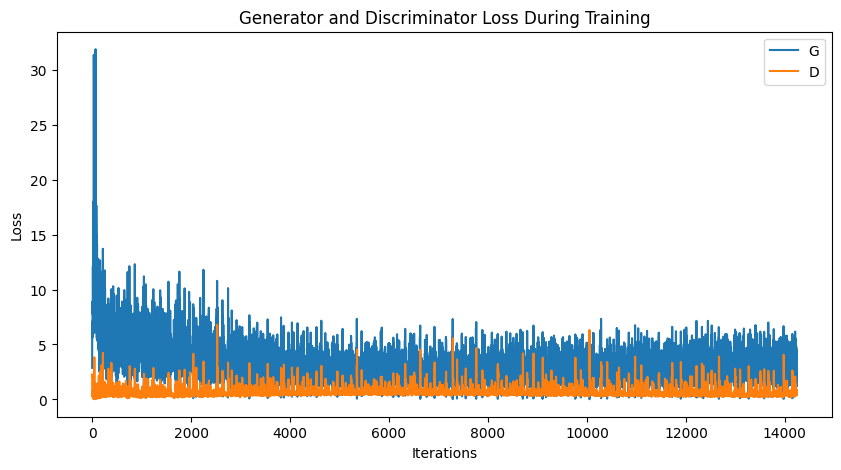

In [ ]:
# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Visualization of G's progression
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())  # Cell output has been cleared to reduce file size

In [ ]:
# Load the best generator model
checkpoint = torch.load('best_generator.pth')
netG.load_state_dict(checkpoint['model_state_dict'])
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

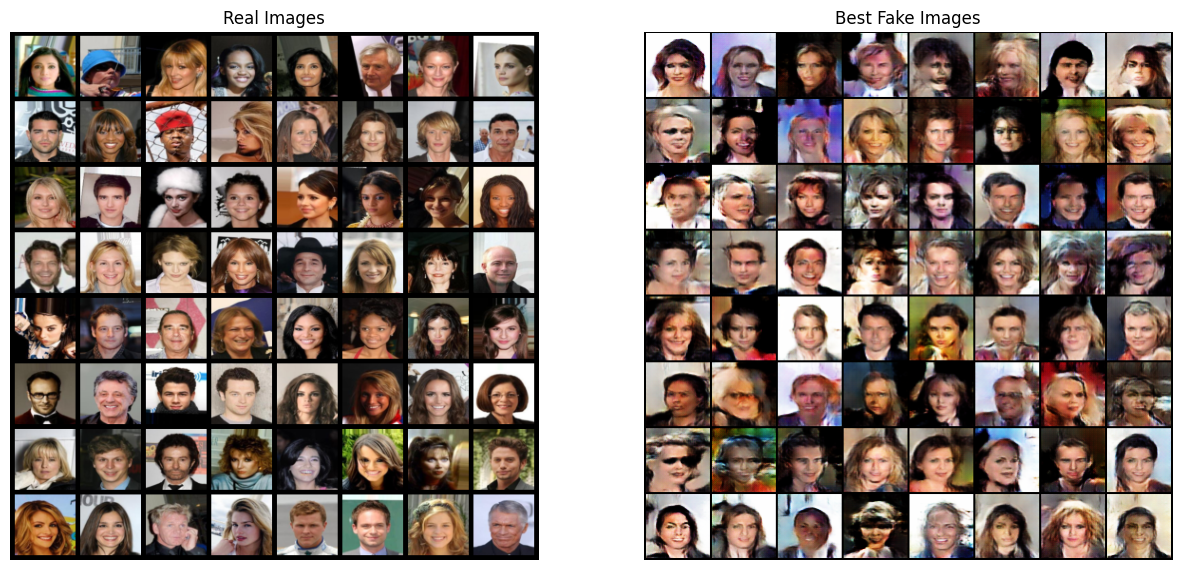

In [ ]:
# Generate images with the best model for visualization
with torch.no_grad():
    # Create a fixed noise vector
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    best_fake_images = netG(fixed_noise).detach().cpu()

# Plotting the real images
real_batch = next(iter(train_loader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Real Images")
real_images_grid = make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu()
plt.imshow(np.transpose(real_images_grid, (1, 2, 0)))

# Plotting the best fake images
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Best Fake Images")
best_fake_images_grid = make_grid(best_fake_images, padding=2, normalize=True)
plt.imshow(np.transpose(best_fake_images_grid, (1, 2, 0)))

plt.show()

## Quantitative Evaluation

In [ ]:
from scipy.linalg import sqrtm
from torchvision.models.inception import inception_v3
from torch.nn.functional import interpolate
from torch.utils.data import TensorDataset

# Function to get features from Inception model
def get_inception_features(model, loader, device):
    model.eval()
    features = []

    with torch.no_grad():
        for data in loader:
            # Extract images from the data
            images = data[0] if isinstance(data, (list, tuple)) else data

            # Resize images to match Inception v3's expected input size
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            images = images.to(device)

            output = model(images)
            features.append(output.cpu().numpy())

    # Concatenate all features into a single numpy array
    features = np.concatenate(features, axis=0)
    return features

In [ ]:
# Fréchet Inception Distance
def calculate_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [ ]:
# Load Inception Model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()
inception_model = inception_model.to(device)

# Calculate features for real images
real_features = get_inception_features(inception_model, test_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 156MB/s] 


In [ ]:
# Generate fake images and calculate features
fake_images = []  # List to store fake images
num_images_to_generate = 100  # Number of images to generate

for _ in range(num_images_to_generate):
    noise = torch.randn(1, nz, 1, 1, device=device)  # Generate random noise
    with torch.no_grad():
        fake_img = netG(noise).detach().cpu()  # Generate fake image
    fake_images.append(fake_img)  # Append generated image to the list

# Convert fake_images list to a single tensor
fake_images = torch.cat(fake_images, dim=0)  # Concatenate all images in the list

# Ensure the shape of fake_images is [N, C, H, W]
print("Shape of fake_images:", fake_images.shape)

# Create a DataLoader for the fake images
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=128, shuffle=False)

# Calculate features for fake images
fake_features = get_inception_features(inception_model, fake_loader, device)

Shape of fake_images: torch.Size([100, 3, 64, 64])


In [ ]:
# Calculate FID
fid_score = calculate_fid(real_features, fake_features)
print('FID score:', fid_score)

FID score: 5.342339453620755e+84


# Pretrained DDPM

## Image Generation

In [ ]:
!pip install diffusers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.3 MB/s eta 0:00:00


In [ ]:
from diffusers import DDPMPipeline

# Set the environment variable for CuBLAS
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# Consistently disable deterministic algorithms
torch.use_deterministic_algorithms(False)

# Generate images with the DDPM
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)

num_images = 5
with torch.no_grad():
    ddpm_images = pipeline(num_images, generator=torch.manual_seed(0)).images

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Generate images with the DCGAN
noise = torch.randn(num_images, nz, 1, 1, device=device)
with torch.no_grad():
  dcgan_images = netG(noise).detach().cpu()

## Model Comparison

In [ ]:
# Function to display images
def show_images(images, title):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        ax = plt.subplot(1, len(images), i + 1)
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0)  # Convert from C, H, W to H, W, C
            img = (img - img.min()) / (img.max() - img.min())  # Normalize
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle(title, y=0.55)  # Adjust title placement with y parameter
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

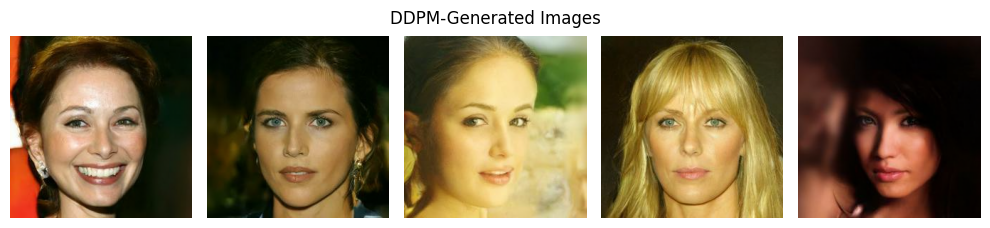

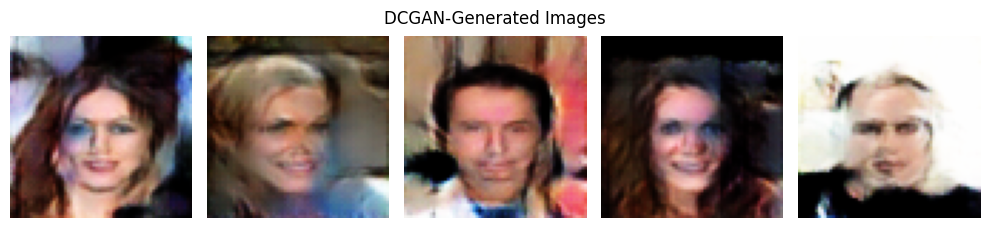

In [ ]:
# Call the function
show_images(ddpm_images, "DDPM-Generated Images")
show_images([dcgan_images[i] for i in range(num_images)], "DCGAN-Generated Images")

# Bonus: VAE

## Encoder Network

In [ ]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # Output: (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),# Output: (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# Output: (256, 4, 4)
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

## Decoder Network

In [ ]:
# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # Output: (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # Output: (3, 64, 64)
            nn.Tanh()  # Tanh for normalized input images
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, 4, 4)  # Unflatten
        return self.conv_layers(z)

## VAE Model

In [ ]:
# Encoder and Decoder in VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Loss Function

In [ ]:
# Loss function
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

## Training Loop

In [ ]:
# Training loop function
def train_vae(model, train_loader, optimizer, epoch, device):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}")
    return avg_train_loss

## Validation Loop

In [ ]:
# Validation loop function
def validate_vae(model, val_loader, epoch, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            val_loss += vae_loss(recon_batch, data, mu, logvar).item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"====> Validation set loss: {avg_val_loss:.4f}")
    return avg_val_loss

## Initializations & Training

In [ ]:
# Hyperparameters
latent_dim = 50
learning_rate = 0.001
num_epochs = 10

# Initialize the VAE model
vae_model = VAE(latent_dim=latent_dim).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# Training and Validation
train_loss_list = []
val_loss_list = []

best_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss = train_vae(vae_model, train_loader, optimizer, epoch, device)
    val_loss = validate_vae(vae_model, val_loader, epoch, device)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(vae_model.state_dict(), 'best_vae_model.pth')

Train Epoch: 1 [0/182339 (0%)]	Loss: 7550.724609
Train Epoch: 1 [12800/182339 (7%)]	Loss: 1214.699707
Train Epoch: 1 [25600/182339 (14%)]	Loss: 1010.872253
Train Epoch: 1 [38400/182339 (21%)]	Loss: 832.789490
Train Epoch: 1 [51200/182339 (28%)]	Loss: 764.604675
Train Epoch: 1 [64000/182339 (35%)]	Loss: 689.608582
Train Epoch: 1 [76800/182339 (42%)]	Loss: 676.368652
Train Epoch: 1 [89600/182339 (49%)]	Loss: 682.008606
Train Epoch: 1 [102400/182339 (56%)]	Loss: 624.251465
Train Epoch: 1 [115200/182339 (63%)]	Loss: 653.627319
Train Epoch: 1 [128000/182339 (70%)]	Loss: 629.880310
Train Epoch: 1 [140800/182339 (77%)]	Loss: 644.754578
Train Epoch: 1 [153600/182339 (84%)]	Loss: 600.000427
Train Epoch: 1 [166400/182339 (91%)]	Loss: 623.742432
Train Epoch: 1 [179200/182339 (98%)]	Loss: 635.156738
====> Epoch: 1 Average loss: 823.2335
====> Validation set loss: 613.9799
Train Epoch: 2 [0/182339 (0%)]	Loss: 621.466064
Train Epoch: 2 [12800/182339 (7%)]	Loss: 633.939453
Train Epoch: 2 [25600/18233

In [ ]:
# Loading the best model
vae_model.load_state_dict(torch.load('best_vae_model.pth'))

<All keys matched successfully>

## Visualization

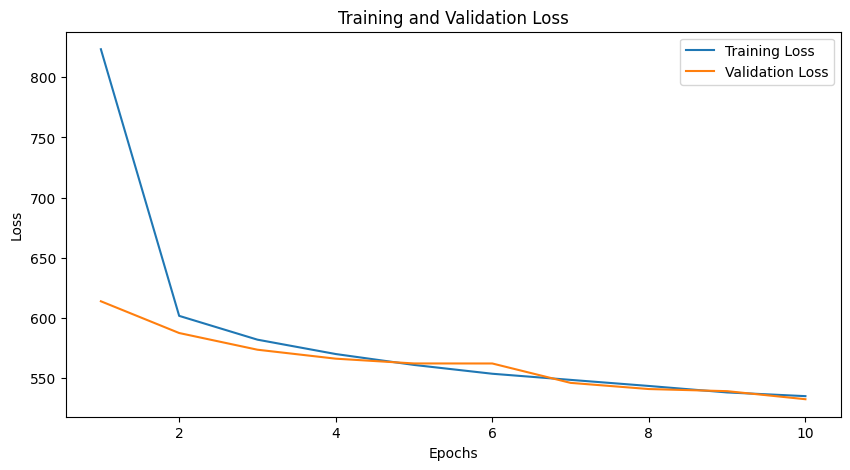

In [ ]:
# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Image Generation

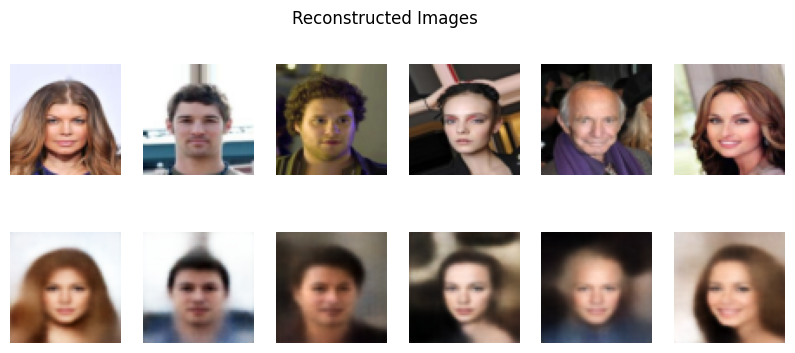

In [ ]:
# Function to visualize reconstruction
def visualize_reconstruction(model, data_loader, device, n_images=6):
    model.eval()
    data_iter = iter(data_loader)
    images = next(data_iter).to(device)
    n_images = min(n_images, len(images))
    with torch.no_grad():
        recon_images, _, _ = model(images)

    fig, axes = plt.subplots(2, n_images, figsize=(10, 4))
    for i in range(n_images):
        # Normalize images for proper display
        original = images[i].cpu().permute(1, 2, 0).numpy()
        original = (original - original.min()) / (original.max() - original.min())
        reconstruction = recon_images[i].cpu().permute(1, 2, 0).numpy()
        reconstruction = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())

        axes[0, i].imshow(original)
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstruction)
        axes[1, i].axis('off')

    fig.suptitle('Reconstructed Images')
    plt.show()


# Call the function
visualize_reconstruction(vae_model, test_loader, device)

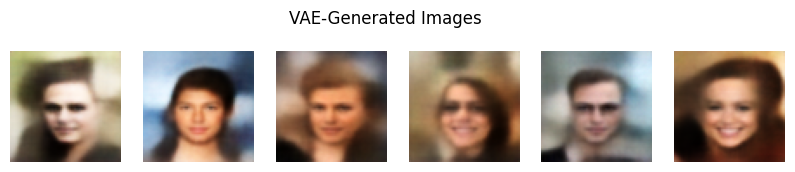

In [ ]:
# Function for latent space sampling and image generation
def generate_images_from_latent(model, device, n_images=6, latent_dim=50):
    model.eval()
    with torch.no_grad():
        # Ensure the latent dimension matches the model's expected input
        z = torch.randn(n_images, latent_dim, device=device)
        generated_images = model.decoder(z)

    fig, axes = plt.subplots(1, n_images, figsize=(10, 2))
    for i in range(n_images):
        img = generated_images[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the images for display
        axes[i].imshow(img)
        axes[i].axis('off')

    fig.suptitle('VAE-Generated Images')
    plt.show()

# Call the function
generate_images_from_latent(vae_model, device)